# STEP #0: PROBLEM STATEMENT  

- Deep dream is a computer vision algorithm created by Alexander Mordvintsev from Google. 
- The algorithm works by creating dream-like effect. It’s like giving humans an extremely powerful drug!
- When you feed in an image to a trained ANN, the neurons fire and generate activations. The deep dream algorithm work by trying to change the input image in a way that would make some of these neurons fire more (boost the neurons firing or activations). 
- You can select which neurons in which layer you are interested in making them fire more prominently. 
- The process is continuously repeated until the input image now contains all features that a specific layer was originally looking for. 
- Example: if a certain layer was expert in recognizing dog faces and you feed in an image of a blue sky, the deep dream algorithm will continuously change the input image and start creating images of dogs faces on top of the blue sky. The process keep repeating until the layer of interest is happy with the results!
- Deep Dream Steps: 
  1. Forward an image through a trained ANN, CNN, ResNet..etc 
  2. Select a layer of choice (first layers capture edges, deep layers capture full shapes such as faces) 
  3. Calculate the activations (output) coming out from the layer of interest. 
  4. Calculate the gradient of the activations with respect to the input image 
  5. Modify the image to increase these activations, and thus enhance the patterns seen by the network resulting in trippy hallucinated image! 
  6. Iterate and repeat over multiple scales
  
  
 * This code is adapted from Tensorflow 2.0 Documentation: https://www.tensorflow.org/beta/tutorials/generative/deepdream
 

# STEP #1: IMPORT LIBRARIES

In [ ]:
!pip install tensorflow-gpu==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 


# STEP #2: IMPORT MODEL WITH PRE-TRAINED WEIGHTS

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

# NOTES:
- The objective of this function is to select a layer and attempt at maximizing the loss which is the activations generated by the layer of interest.
- We can select any layer we choose, early layers generate simple features such as edges and deep layers generate more complex features such as entire face, car or tree.
- Inception network has multiple concatenated layers named 'mixed' 

In [ ]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']

layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
deepdream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# STEP #3: GET AN IMAGE AND PREPROCESS IT

In [ ]:
Sample_Image= tf.keras.preprocessing.image.load_img(r'StaryNight.jpg', target_size = (225, 375))

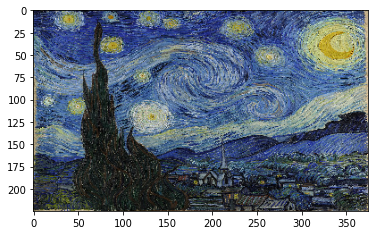

In [ ]:
plt.imshow(Sample_Image)

In [ ]:
np.shape(Sample_Image)

(225, 375, 3)

In [ ]:
# Normalize the input image

Sample_Image = np.array(Sample_Image)/255.0
Sample_Image.shape

(225, 375, 3)

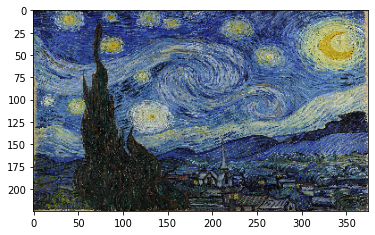

In [ ]:
plt.imshow(Sample_Image)

In [ ]:
# Let's make sure that the image in fact normalized!
Sample_Image.max()

1.0

In [ ]:
Sample_Image.min()

0.0

# STEP #4: LET'S RUN THE PRETRAINED MODEL AND EXPLORE ACTIVATIONS

In [ ]:
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)
Sample_Image.shape

(225, 375, 3)

In [ ]:
 Sample_Image = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(Sample_Image))


In [ ]:
Sample_Image = tf.expand_dims(Sample_Image, axis = 0)
np.shape(Sample_Image)

TensorShape([1, 225, 375, 3])

In [ ]:
# Let's run the model by feeding in our input image and taking a look at the activations "Neuron outputs"
activations = deepdream_model(Sample_Image)
activations

[<tf.Tensor: shape=(1, 12, 21, 768), dtype=float32, numpy=
 array([[[[0.        , 0.6254893 , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.6352106 , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.02113532, 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
 
         [[0.        , 0.00612895, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.13483259, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
        

In [ ]:
len(activations)

2

In [ ]:
print(np.shape(activations))

(2, 1, 12, 21, 768)


# STEP #4: DEEP DREAM LOSS CALCULATION

- The objective of this function is to select a layer and attempt at maximizing the loss which is the activations generated by the layer of interest.
- We can select any layer we choose, early layers generate simple features such as edges and deep layers generate more complex features such as entire face, car or tree.
- Inception network has multiple concatenated layers named 'mixed', you can select any layer or more from mixed0 to mixed10.
- We will calculate the loss which represents the sum of activations for a given layer. 
- Most of the time we wanted to minimize the loss 'error' via gradient descent, however, in deep dream we are going to maximize the loss!! 
- This is done by perforing gradient 'ascent' and not gradient 'descent'. 

In [ ]:
def calc_loss(image, model):
# Function used for loss calculations
# It works by feedforwarding the input image through the network and generate activations
# Then obtain the average and sum of those outputs

  img_batch = tf.expand_dims(image, axis=0) # Convert into batch format
  layer_activations = model(img_batch) # Run the model
  print('ACTIVATION VALUES (LAYER OUTPUT) =\n', layer_activations)
  

  
  losses = [] # accumulator to hold all the losses
  for act in layer_activations:
    loss = tf.math.reduce_mean(act) # calculate mean of each activation 
    losses.append(loss)
  
  print('LOSSES (FROM MULTIPLE ACTIVATION LAYERS) = ', losses)
  print('SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)= ', tf.reduce_sum(losses))

  return  tf.reduce_sum(losses) # Calculate sum 

In [ ]:
# Let's test the function
Sample_Image = tf.keras.preprocessing.image.load_img(r'StaryNight.jpg', target_size=(225, 375))
Sample_Image = np.array(Sample_Image)/255.0
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)
Sample_Image = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(Sample_Image))

loss = calc_loss(Sample_Image, deepdream_model)

ACTIVATION VALUES (LAYER OUTPUT) =
 [<tf.Tensor: shape=(1, 12, 21, 768), dtype=float32, numpy=
array([[[[0.        , 0.6254893 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.6352106 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.02113532, 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.00612895, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.13483259, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
       

# STEP #5: GRADIENT ASCENT CALCULATIONS

- In this step, we will rely on the loss that has been calculated in the previous step and calculate the gradient with respect to the given input image and then add it to the input original image. 
- Doing so iteratively will result in feeding images that continiously and increasingly excite the neurons and generate more dreamy like images!
- Check out the Appendix for more info on tf.gradienttape()


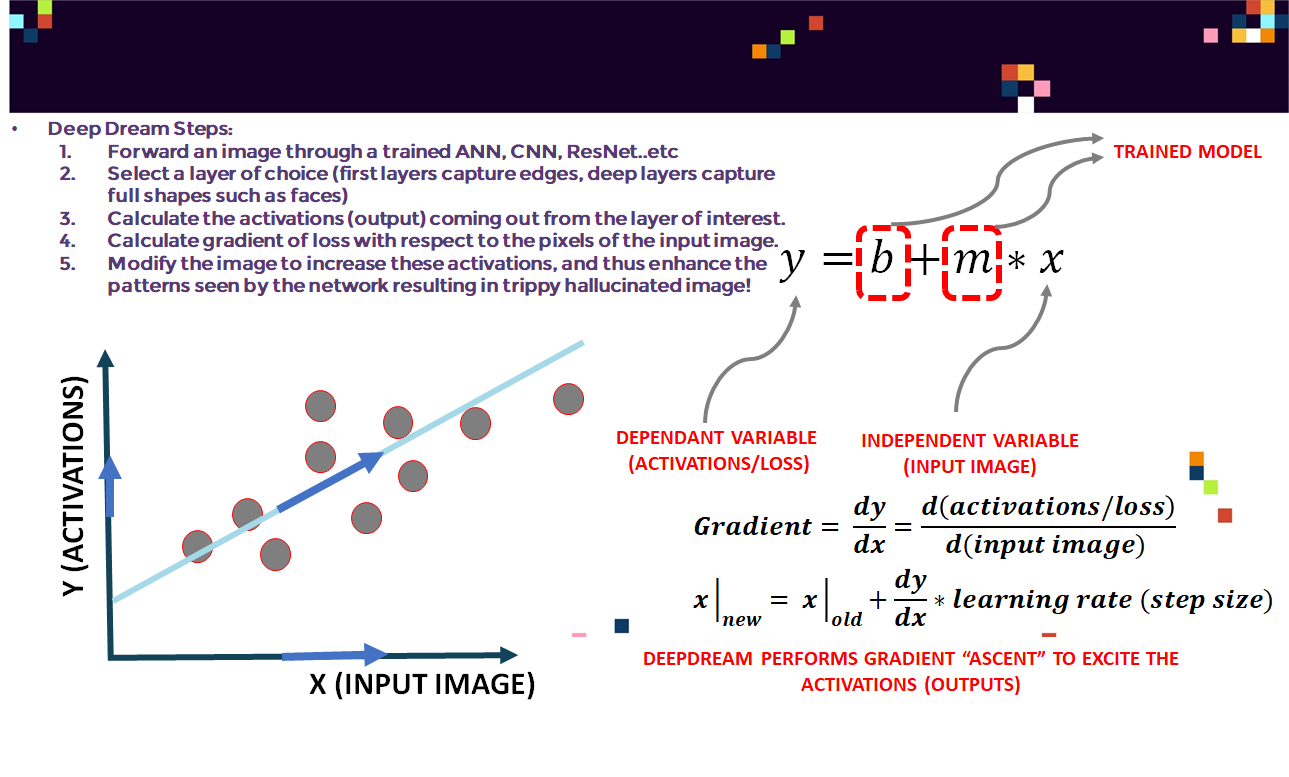

In [ ]:
@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to 'img'
      # 'GradientTape' only watches 'tf.Variable's by default
      tape.watch(image)
      loss = calc_loss(image, model) # call the function that calculate the loss

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    # The syntax is as follows: dy_dx = g.gradient(y, x) 
    gradients = tape.gradient(loss, image)

    print('GRADIENTS =\n', gradients)
    print('GRADIENTS SHAPE =\n', np.shape(gradients))

    # tf.math.reduce_std computes the standard deviation of elements across dimensions of a tensor
    gradients /= tf.math.reduce_std(gradients)  

    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)
    print(image)

    return loss, image

In [ ]:
def run_deep_dream_simple(model, image, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    loss, image = deepdream(model, image, step_size)
    
    if step % 100 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(deprocess(image))
      plt.show()
      print ("Step {}, loss {}".format(step, loss))

  # clear_output(wait=True)
  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)

In [ ]:
def deprocess(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)


In [ ]:
Sample_Image= tf.keras.preprocessing.image.load_img(r'StaryNight.jpg', target_size = (225, 375))
Sample_Image = np.array(Sample_Image)
dream_img = run_deep_dream_simple(model=deepdream_model, image=Sample_Image, steps=2000, step_size=0.001)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# you can run the algorithm at various sizes of the image
OCTAVE_SCALE = 1.3

Sample_Image= tf.keras.preprocessing.image.load_img(r'StaryNight.jpg', target_size = (225, 375))

image = tf.constant(np.array(Sample_Image))
base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

for n in range(5):
  new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)
  image = tf.image.resize(image, new_shape).numpy()

  image = run_deep_dream_simple(model=deepdream_model, image=image, steps=400, step_size=0.001)


Output hidden; open in https://colab.research.google.com to view.

# APPENDIX #1: GRADIENT CALCULATION AND TF.GRADIENTTAPE()

- tf.GradientTape() is used to record operations for automatic differentiation
- For example, Let's assume we have the following functions y = x^3. 
- The gradient at x = 2 can be computed as follows: dy_dx = 3 * x^2 = 3 * 2^2 = 12. 


In [ ]:
x = tf.constant(2.0)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x * x
dy_dx = g.gradient(y, x) # Will compute to 12

In [ ]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=12.0>